# Heisenberg XXX model

$$ H_{\text{TFIM}} = \sum_{j=1}^{L}(X_jX_{j+1}+Y_jY_{j+1}+Z_jZ_{j+1}) $$

pip install qrisp 

https://www.qrisp.eu


In [115]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import svds
from qrisp.operators import X, Y, Z
from qrisp import QuantumVariable
from qrisp.vqe.problems.heisenberg import *
from qrisp import QPE
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

## Define Heisenberg Hamiltonian

In [43]:
def create_instance(L, type='Singlet'):

    # Create a graph
    G = nx.Graph()
    G.add_edges_from([(k,k+1) for k in range(L-1)]) 

    def create_heisenberg_hamiltonian(G):
        H = sum(X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) for (i,j) in G.edges())
        return H

    H = create_heisenberg_hamiltonian(G)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=1, which='SA')
    E0 = eigenvalues[0]

    # Rescale to E0=0
    H2 = H - E0

    M = H2.to_sparse_matrix()
    u, s, vt = svds(M, k=1, which='LM')
    spectral_norm = s[0]

    E_max = spectral_norm

    # Rescale such that spectrum in [0,1)
    H3 = H2*(1/(E_max+1))

    M = H3.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')

    # Ground state
    psi_0 = eigenvectors[:,0]

    E0 = eigenvalues[0]
    E1 = eigenvalues[1]

    delta = E1-E0
    #print('Spectral gap:', delta)
    #print('Ground state energy:', E0)

    if type=='VQE':
        # VQE warm start
        vqe = heisenberg_problem(G,1,0)
        U_0 = vqe.train_function(QuantumVariable(G.number_of_nodes()),depth=1,max_iter=100)

    if type=='Singlet':
        # Tensor product of singlet states
        M = nx.maximal_matching(G)
        U_0 = create_heisenberg_init_function(M)

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    psi = qv.qs.statevector_array()
    F0 = np.abs(np.dot(psi.conj().transpose(),psi_0))**2
    print('Initial Fidelity', F0)

    return G, H3, U_0, psi_0


# Benchmarking

In [42]:
def prepare_ground_state(precision, steps, G, H, U_0, psi_0, results_dict):

    result = dict()

    qv = QuantumVariable(G.number_of_nodes())
    U_0(qv)

    # Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps 
    # Note: 5 steps are insufficient to obtain the ground state energy within error 0.1 (10 steps are sufficent)
    exp_H = H.trotterization(order=2,forward_evolution=False)

    qpe_res = QPE(qv,exp_H,precision=precision,kwargs={"t":2*np.pi,"steps":steps},iter_spec=True)

    qc = qpe_res.qs.compile()
    tqc = qc.transpile(basis_gates=["cz","u"])

    result["ops"] = tqc.count_ops()
    result["depth"] = tqc.depth()

    results = qpe_res.get_measurement(precompiled_qc=qc)
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_results)
    P0 = sorted_results[0]
    #print('Success probability:', P0)
    result["P0"] = P0

    #qc = qpe_res.qs.compile()

    n = H.find_minimal_qubit_amount()

    for i in range(qc.num_qubits() - n):
        qc.qubits.insert(0, qc.qubits.pop(-1))

    phi = qc.statevector_array()[:2**n]
    phi = phi/np.linalg.norm(phi)

    F0 = (np.abs(np.dot(phi.conj().transpose(),psi_0))**2)
    #print('Fidelity:', F0)
    result["F0"] = F0

    results_dict[precision] = result



In [67]:
def benchmark(L):

    G, H, U_0, psi_0 = create_instance(L, type='Singlet')
    results_dict = dict()
    precision_range = [1,2,3,4,5]
    for precision in precision_range:
        prepare_ground_state(precision, 2, G, H, U_0, psi_0, results_dict)

    return results_dict


In [68]:
benchmark_results = dict()
for L in range(10,22,2):
    res = benchmark(L)
    benchmark_results[L] = res


Initial Fidelity 0.6826139052502765                                                  
Simulating 15 qubits.. |████████████████▍                                    | [ 31%]

KeyboardInterrupt: 

Simulating 15 qubits.. |████████████████▋                                    | [ 32%]

In [ ]:
# Save benchmark data
current_datetime = datetime.now()
date_time_string = current_datetime.strftime("%m-%d-%H")
#save_data(benchmark_results,'data_PRL/benchmarks_QPE_Singlet'+date_time_string)

## Plots QITE vs QPE

In [113]:
# Load data (transpilation to {CZ,U3}), 2 steps 2nd order Trotterization
results_10 = load_data('data_PRL/benchmarks_2nd_L=10_04-17-19') 
results_12 = load_data('data_PRL/benchmarks_2nd_L=12_04-17-21')
results_14 = load_data('data_PRL/benchmarks_2nd_L=14_04-17-21')  
results_16 = load_data('data_PRL/benchmarks_2nd_L=16_04-17-22')  
results_18 = load_data('data_PRL/benchmarks_2nd_L=18_04-17-23')  
results_20 = load_data('data_PRL/benchmarks_2nd_L=20_04-18-11') 

results_QITE = dict()
results_QITE[10] = results_10
results_QITE[12] = results_12
results_QITE[14] = results_14
results_QITE[16] = results_16
results_QITE[18] = results_18
results_QITE[20] = results_20

results_QPE = dict()
results_QPE[0] = load_data('data_PRL/benchmarks_QPE_Singlet_04-25-14')
results_QPE[1] = load_data('data_PRL/benchmarks_QPE_VQE_04-25-15')


In [110]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(23)

In [87]:
def create_heisenberg_hamiltonian_(G, J):
    H = sum(J*( X(i)*X(j)+Y(i)*Y(j)+Z(i)*Z(j) ) for (i,j) in G.edges())
    return H

def calculate_spectra(L):
    G = nx.Graph()
    G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

    J = 1
    H = create_heisenberg_hamiltonian_(G, J)

    M = H.to_sparse_matrix()
    eigenvalues, eigenvectors = eigsh(M, k=2, which='SA')
    return eigenvalues, eigenvectors

x_val=list(range(4,22,2))

spectra = dict()
for L in x_val:
    spectra[L] = calculate_spectra(L) 

E0_val = dict()
E1_val = dict()
E0_vec = dict()
E1_vec = dict()

for L in x_val:
    E0_val[L] = spectra[L][0][0]
    E1_val[L] = spectra[L][0][1]

    E0_vec[L] = spectra[L][1][:,0]
    E1_vec[L] = spectra[L][1][:,1]

/var/folders/1z/61mvq94131s6zhfjfhwzpfwr0000gn/T/ipykernel_31278/2538786273.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


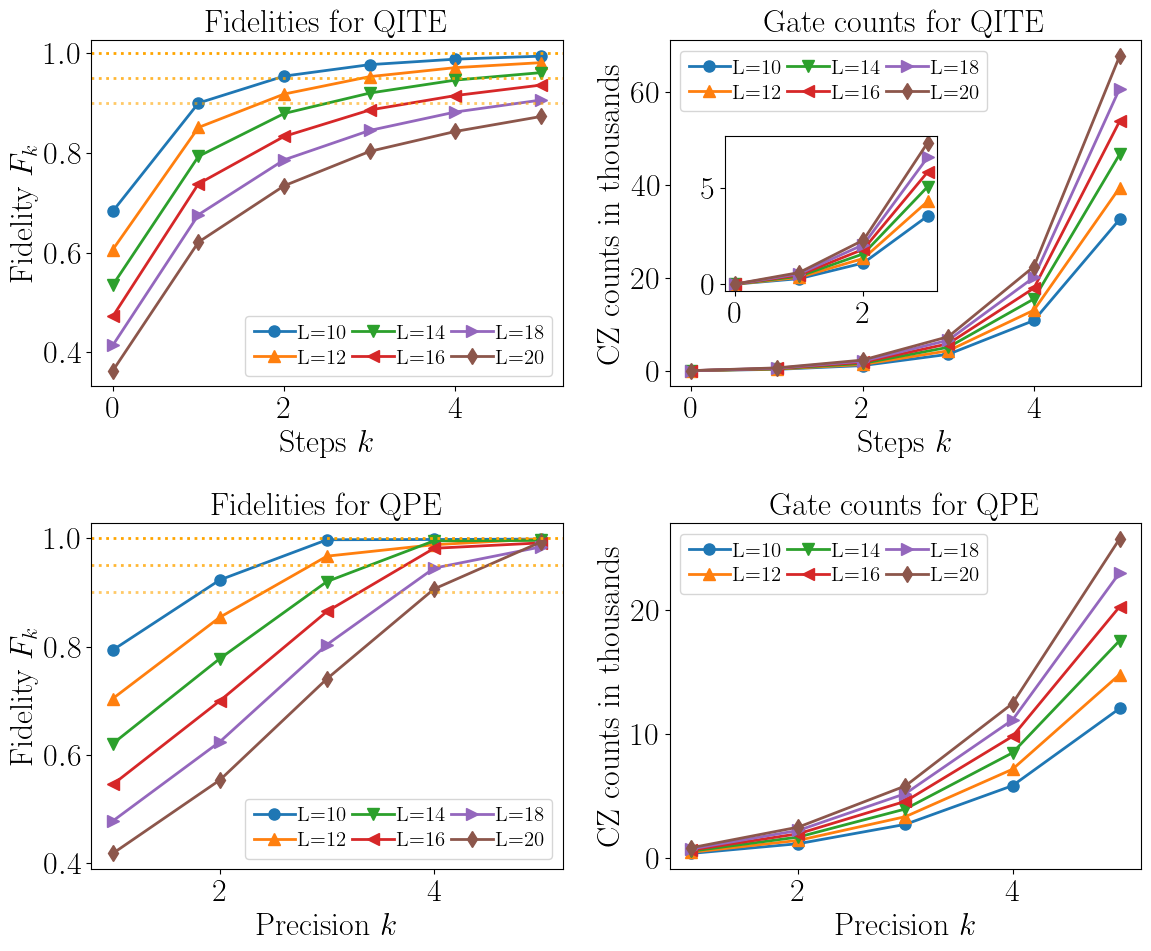

In [147]:
import matplotlib.pyplot as plt

index = 0 # 0 Singlet, 1 VQE
markers = ['o', '^', 'v', '<', '>', 'd']

fig, ((axF_QITE, axCZ_QITE), (axF_QPE, axCZ_QPE)) = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"width_ratios": [1,1]})

###############################################################################
# SUBPLOT 1: Fidelity QITE
###############################################################################

steps = list(range(0,6))

for i,L in enumerate(list(range(10,22,2))):
    results = results_QITE[L]

    psi = E0_vec[L] # ground state
    states = results[index]["statevectors"]
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    axF_QITE.plot(steps, fidelities, marker=markers[i], label=r'L='+str(L))


axF_QITE.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF_QITE.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF_QITE.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF_QITE.legend(loc="best", ncols=3, fontsize=15)
axF_QITE.set_xlabel(r"Steps $k$")
axF_QITE.set_ylabel(r"Fidelity $F_k$")
axF_QITE.set_title(r"Fidelities for QITE")

###############################################################################
# SUBPLOT 2: CZ count QITE
###############################################################################

for i,L in enumerate(list(range(10,22,2))):
    results = results_QITE[L]

    cz = np.array([results[index]["circuit_data"][0][k]['cz']/1000 for k in steps])
    axCZ_QITE.plot(steps, cz, marker=markers[i], label=r'L='+str(L))

axCZ_QITE.legend(loc="best", ncols=3, fontsize=15)
axCZ_QITE.set_xlabel(r"Steps $k$")
axCZ_QITE.set_ylabel(r"CZ counts in thousands")
axCZ_QITE.set_title(r"Gate counts for QITE")

###############################################################################
# Inset plot: Zoom in CZ count QITE
###############################################################################

steps = list(range(0,4))

# Define inset axes
axCZ_QITE_zoom = inset_axes(axCZ_QITE, width="45%", height="45%", loc="center left", bbox_to_anchor=(0.1, 0, 1, 1),
                  bbox_transform=axCZ_QITE.transAxes,)

for i,L in enumerate(list(range(10,22,2))):
    results = results_QITE[L]

    cz = np.array([results[index]["circuit_data"][0][k]['cz']/1000 for k in steps])
    axCZ_QITE_zoom .plot(steps, cz, marker=markers[i], label=r'L='+str(L))

###############################################################################
# SUBPLOT 1: Fidelity QPE
###############################################################################

steps = list(range(1,6))

for i,L in enumerate(list(range(10,22,2))):
    fidelities = [results_QPE[index][L][k]['F0'] for k in steps]
    axF_QPE.plot(steps, fidelities, marker=markers[i], label=r'L='+str(L))

axF_QPE.axhline(y=1, color="orange", linestyle=':', alpha=1.0)
axF_QPE.axhline(y=0.95, color="orange", linestyle=':', alpha=0.8)
axF_QPE.axhline(y=0.9, color="orange", linestyle=':', alpha=0.6)

axF_QPE.legend(loc="best", ncols=3, fontsize=15)
axF_QPE.set_xlabel(r"Precision $k$")
axF_QPE.set_ylabel(r"Fidelity $F_k$")
axF_QPE.set_title(r"Fidelities for QPE")

###############################################################################
# SUBPLOT 2: CZ count QPE
###############################################################################

for i,L in enumerate(list(range(10,22,2))):
    cz = [results_QPE[index][L][k]['ops']['cz']/1000 for k in steps]
    axCZ_QPE.plot(steps, cz, marker=markers[i], label=r'L='+str(L))

axCZ_QPE.legend(loc="best", ncols=3, fontsize=15)
axCZ_QPE.set_xlabel(r"Precision $k$")
axCZ_QPE.set_ylabel(r"CZ counts in thousands")
axCZ_QPE.set_title(r"Gate counts for QPE")

plt.tight_layout()
plt.savefig("plots_PRL/QITE_QPE_Heisenberg_Singlet.pdf")
plt.show()